<h1 style="text-align: center; vertical-align: middle;">Numerical Methods of Accelerator Physics</h1>
<h2 style="text-align: center; vertical-align: middle;">Lecture by Dr. Adrian Oeftiger</h2>

<img src="./img/etit.png" style="width: 20%; margin: auto;" />

<h3 style="text-align: center; vertical-align: middle;">Part 6: 02.12.2022</h3>

<h2>Run this notebook online!</h2>

Interact and run this jupyter notebook online:

<div class="alert alert-block alert-info" style="text-align:center;">
1. via the public mybinder.org service: <br />

<p style="text-align: center; margin-left, margin-right: auto; width: 100%;">
<a href="https://mybinder.org/v2/gh/aoeftiger/TUDa-NMAP-06/v1.1"><img src="./img/binder_logo.svg" /></a>
</p>
</div>

<div class="alert alert-block alert-success" style="text-align:center;">
2. on the <a href="https://tu-jupyter-i.ca.hrz.tu-darmstadt.de/">local TU Darmstadt jupyterhub $\nearrow$</a> (using your TU ID)

$\implies$ make sure you installed all the required python packages (see the [README](./README.md))!
</div>

Finally, also find this lecture rendered [as HTML slides on github $\nearrow$](https://aoeftiger.github.io/TUDa-NMAP-06/) along with the [source repository $\nearrow$](https://github.com/aoeftiger/TUDa-NMAP-06).

<h2>Run this first!</h2>

Imports and modules:

In [1]:
from config import (np, plt, plot_rfwave, tqdm, trange, 
                    beta, gamma, Machine, track_one_turn,
                    charge, mass, emittance, hamiltonian, 
                    plot_hamiltonian, plot_rf_overview,
                    plot_dist, plot_mp)
from scipy.constants import m_p, e, c
%matplotlib inline

If the progress bar by `tqdm` (`trange`) in this document does not work, run this:

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


<h2 style="color: #b51f2a">Refresher!</h2>

- Monte-Carlo Techniques: sampling of distribution functions
- uniformly distributed pseudo-random numbers (with Linear Congruential Generators)
- Gaussian distributed pseudo-random numbers (Box-Muller method)
- Hamiltonian for synchrotron motion (rf bucket, stationary case and small-amplitude approximation)
- Equilibrium distributions
- Equilibrium at small amplitudes: harmonic oscillation $\leftrightarrow$ Gaussian distribution
- Rejection sampling

<h2 style="color: #b51f2a">Today!</h2>

1. Simulation of Full CERN PS Acceleration Ramp
2. Initialisation of Phase Space (Cont'd)
3. Emittance Preservation & Injection Errors

<div style="text-align: center; width:100%;">
    <h2>Part I: Simulation of Full CERN PS Acceleration Ramp</h2>
</div>

<h2>CERN PS Parameters (once more)</h2>

For reference, the CERN Proton Synchrotron (PS) parameters:
- has a circumference of 2π·100m
- takes protons from the PS Booster at a kinetic energy of 2GeV corresponding to a γ of 3.13
- injects with 50kV of rf voltage, up to 200kV for ramp
- runs at harmonic $h=7$
- has a momentum compaction factor of $\alpha_c=0.027$
- typical acceleration rate of (up to) $\dot{B}=2$ T/s, the bending radius is $\rho=70.08$ m

<h2>Exercise</h2>

Let us properly simulate the <b>full acceleration ramp</b> (including crossing transition) with a bunch of small phase-space area (emittance)! 

You as operator in the (simulation) control centre shall pay attention to <b>preserve the longitudinal emittance</b> throughout the acceleration!

$\implies$ Observe the tracking results. Can you explain what happens? Think about what you need to change in the machine settings to achieve emittance preservation.

We start by instantiating the PS, `Machine(...)`:

(<i>hint: hit both `Shift+Tab` keys inside the parentheses `()` below to get info about the possible arguments to `Machine`</i>)

In [3]:
m = Machine()

assert m.phi_s > 0, "machine is not accelerating...?"

If you want to check the rf systems setup, uncomment (remove `#`) the following plot command from the previous lecture:

In [4]:
# plot_rf_overview(m);

We initialise a Gaussian bunch distribution with very small rms bunch length $\sigma_z=1\,$m (so that the small-amplitude approximation holds):

In [5]:
sigma_z = 1

The "matched" rms momentum spread $\sigma_{\Delta p}$ (remember, $\sigma_{\Delta p}$ and $\sigma_z$ are linked via equal Hamiltonian values $\mathcal{H}_0$, the equilibrium condition):

In [6]:
sigma_deltap = np.sqrt(
    2 * m.p0() / -m.eta(0) * 
    charge * m.voltage * np.pi * m.harmonic / (beta(gamma(m.p0())) * c * m.circumference**2)
) * sigma_z

<h2>Generating Macro-particles via Box-Muller</h2>

(<i>Notabene: with this small emittance / rms size in phase space, the Gaussian tails cannot reach outside the separatrix due to numerical reasons, so no rejection sampling is needed in this particular case.</i>

<i>Finite machine precision at FP64 is $\varepsilon\approx 2^{-53}$, therefore one can only generate pseudo-random numbers from the Gaussian distribution up to an amplitude of $x$ where $\exp(-x^2/2)=2^{-53}$, i.e.</i>

In [7]:
np.sqrt(2 * -np.log(2**-53))

8.571674348652905

<i>$\implies$ given $\sigma_z=1\,$</i>m<i>, no particles can be generated outside of $z=8.6\,$m and the equivalent Hamiltonian contour in phase space)</i>

In [8]:
N = 1000

In [9]:
np.random.seed(12345)

z = np.random.normal(loc=0, scale=sigma_z, size=N)
deltap = np.random.normal(loc=0, scale=sigma_deltap, size=N)

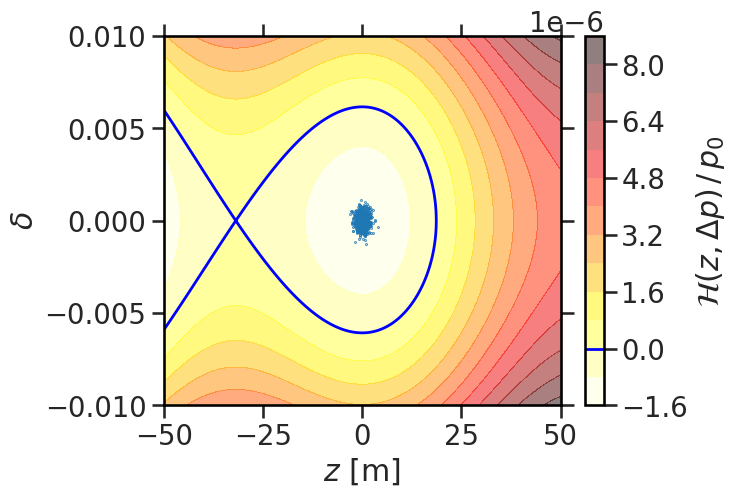

In [10]:
plot_hamiltonian(m)
plt.scatter(z, deltap / m.p0(), marker='.', s=1);

<h2>Compute Duration of Ramp</h2>

$(\Delta\gamma)_\mathrm{turn} = \cfrac{\Delta E_\mathrm{tot}}{m_0c^2} = \cfrac{qV\sin(\varphi_s)}{m_0c^2}$

such that accelerating from $\gamma_\mathrm{ref}=3.1$ to $\gamma_\mathrm{ref}=27.7$ takes as many turns as

$n_\mathrm{turns}=\cfrac{27.7-3.1}{(\Delta\gamma)_\mathrm{turn}}$

In [11]:
dgamma_per_turn = charge * m.voltage * np.sin(m.phi_s) / (mass * c**2)
n_turns = int((27.7 - 3.1) / dgamma_per_turn)
n_turns

262075

Record longitudinal emittance during tracking:

In [12]:
epsn_z = np.zeros(n_turns, dtype=np.float64)

epsn_z[0] = emittance(z, deltap)

Let's go tracking! ($\approx 1\,$min total time)

In [13]:
for i_turn in trange(1, n_turns):
    z, deltap = track_one_turn(z, deltap, m)
    
    epsn_z[i_turn] = emittance(z, deltap)

  0%|          | 0/262074 [00:00<?, ?it/s]

We have reached the extraction energy of $\gamma=27.7$:

In [14]:
m.gamma_ref

27.72990291334168

Check that we properly conserved the rms emittance:

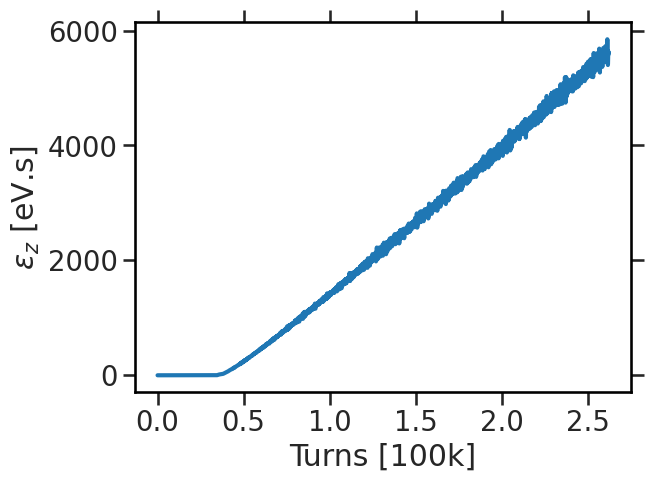

In [15]:
plt.plot(np.arange(n_turns) / 100000, epsn_z / e)

plt.xlabel('Turns [100k]')
plt.ylabel('$\epsilon_z$ [eV.s]');

<span style="color: #e6541a;">$\implies$ use the phase-space plots and </span>`plot_hamiltonian`<span style="color: #e6541a;"> as well as </span>`plot_rf_overview`<span style="color: #e6541a;"> above as diagnostics. You can stop the tracking after a certain turn to investigate, e.g. by changing the value of </span>`n_turns`<span style="color: #e6541a;"> inside the </span>`trange`<span style="color: #e6541a;"> counter in the </span>`for`<span style="color: #e6541a;"> loop.</span>

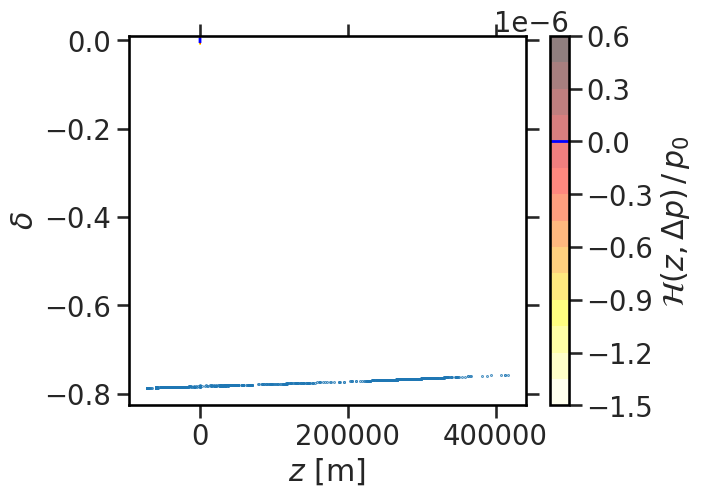

In [16]:
plot_hamiltonian(m);
plt.scatter(z, deltap / m.p0(), marker='.', s=1);

<div style="text-align: center; width:100%;">
    <h2>Part II: Initialisation of Phase Space (Cont'd)</h2>
</div>

<h2>Matching with Nonlinear Hamiltonians</h2>

Last lecture we looked at the thermal equilibrium distribution in small-amplitude approximation ($=$ Gaussian distribution) to generate a bunch of macro-particles in longitudinal phase space.

For the Gaussian distribution, the target rms bunch length $\hat{\sigma}_z$ directly enters the generator as a multiplication factor: a random variable $x$ following a standard Gaussian normal distribution has $\sigma_x=1$, then $z=\hat{\sigma}_z\cdot x$ will provide the Gaussian normal distributed random variable $z$ with $\sigma_z=\hat{\sigma}_z$.

For a general thermal equilibrium distribution in a nonlinear Hamiltonian, the PDF becomes $\psi=\psi(\mathcal{H})\propto \exp(\mathcal{H}/\mathcal{H}_0)$ for a constant parameter $\mathcal{H}_0$. $\mathcal{H}_0$ is determined through $\hat{\sigma}_z$ such that $\psi$ yields a distribution with corresponding rms bunch length. For nonlinear $\mathcal{H}$, the parameter $\mathcal{H}_0$ will generally have to be computed numerically, this process is referred to as <b>"matching"</b>!

In the following we will investigate the full nonlinear Hamiltonian case, $\psi=\psi(\mathcal{H})$.

Let's work with the python library `PyHEADTAIL` (simulation suite for beam dynamics):

In [17]:
!pip install PyHEADTAIL

If you are on the TUDa jupyterhub, please run instead ```!TMPDIR="`pwd`" pip install PyHEADTAIL --prefix="`pwd`/requirements"```

`PyHEADTAIL` provides a class to represent rf buckets (for plotting as well as matching):

In [18]:
from PyHEADTAIL.trackers.rf_bucket import RFBucket

PyHEADTAIL v1.16.0


We define a convenience function to provide `RFBucket` instances given a `Machine` instance:

In [19]:
def get_pyht_rfbucket(machine):
    m = machine
    deltap_per_turn = charge * m.voltage / (beta(gamma(m.p0())) * c) * np.sin(m.phi_s)
    rfb = RFBucket(m.circumference, m.gamma_ref, mass, charge, [m.alpha_c], deltap_per_turn, 
                   [m.harmonic], [m.voltage], [np.pi + m.phi_s])
    # PyHEADTAIL has a different convention for the phase and is offset by π compared to our lecture
    return rfb

<h2>Visualising the Distributions in the RF Bucket</h2>

In [20]:
m = Machine(gamma_ref=3.13)

In [21]:
rfb = get_pyht_rfbucket(m)

In [22]:
from PyHEADTAIL.particles.rfbucket_matching import (
    ThermalDistribution, WaterbagDistribution, ParabolicDistribution)

In [23]:
sigma_z = 8

Computing the (initial) guess for $\mathcal{H}_0$ based on the small-amplitude approximation:

In [24]:
H0 = rfb.guess_H0(sigma_z, from_variable='sigma')
H0

153.62263838682642

<h2>Reminder: Equilibrium at Small Amplitudes</h2>

<i>Small-amplitude approximation</i> and a stationary rf bucket below transition, $\varphi_s=0$: particles follow harmonic oscillation with

$$\mathcal{H}_\mathrm{stat,small}(z,\Delta p) = \frac{1}{2}\frac{-\eta}{p_0} \Delta p{}^2 + \frac{qV}{\beta c}\cdot \cfrac{\pi h}{C^2}\cdot z^2
$$

The PDF of the <i>thermal distribution</i> becomes

$$\psi(\mathcal{H})\propto\exp\left(\frac{\mathcal{H}_{stat,small}}{\mathcal{H}_0}\right)=\exp\left(\frac{1}{2}\frac{\frac{qV\,2\pi h}{\beta c C^2}}{\mathcal{H}_0}\cdot z^2\right) \cdot \exp\left(\frac{1}{2}\frac{-\eta/p_0}{\mathcal{H}_0}\cdot \Delta p^2\right)$$

which is simply a <b>bi-Gaussian distribution</b> in $\Delta p$ and $z$! The constant $\mathcal{H}_0$ is determined by a choice of the rms bunch length $\sigma_z$ (or equivalently the rms momentum deviation $\sigma_\delta=\sigma_{\Delta p}/p_0$):

$$\mathcal{H}_0 = \mathcal{H}_\mathrm{stat,small}(\sigma_z,\Delta p=0) = \frac{qV}{\beta c}\cdot \cfrac{\pi h}{C^2}\cdot \sigma_z{}^2 \color{red}{=} \mathcal{H}_\mathrm{stat,small}(z=0,\sigma_{\Delta p}) = \frac{1}{2}\frac{-\eta}{p_0} \sigma_{\Delta p}{}^2$$

$\implies$ as equilibrium or <b>matching condition</b>, <b>$\sigma_z$ and $\sigma_\delta$ are linked</b> to each other via equal Hamiltonian values!

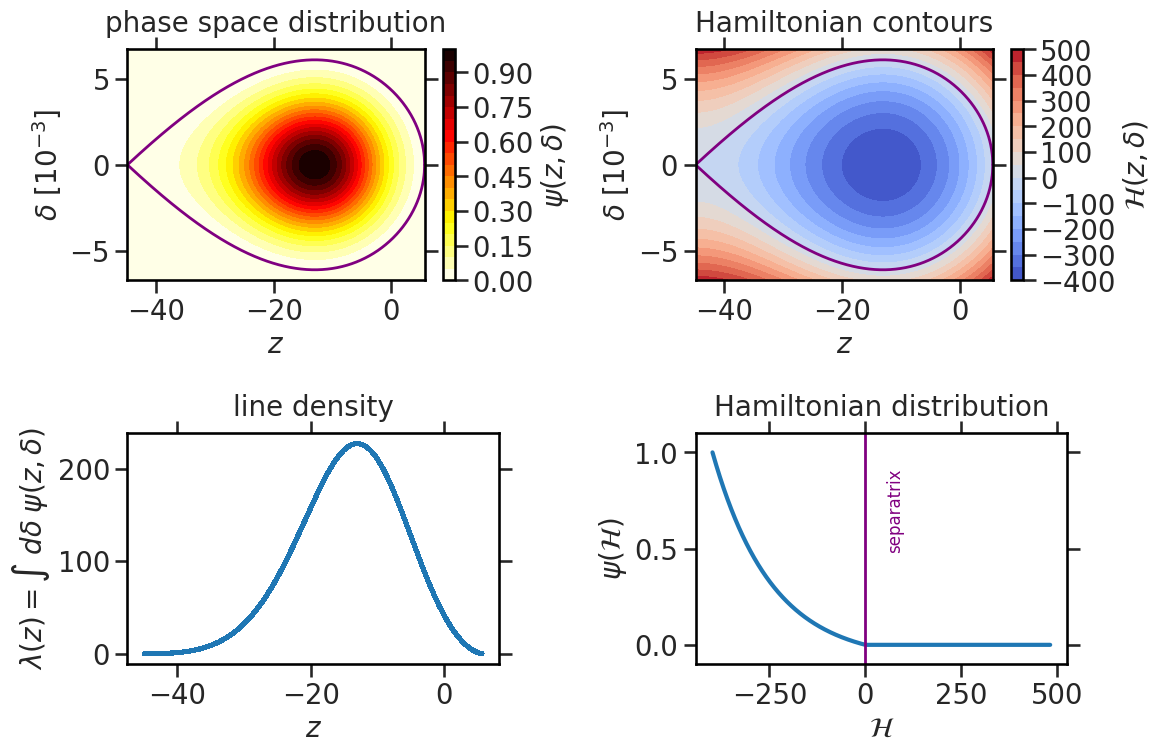

In [25]:
plot_dist(ThermalDistribution, rfb, H0=H0);

<p style="color: #e6541a;">$\implies$ adjust the $\sigma_z$ and observe the impact of the non-linearities on the matched $\psi$ (small $\sigma_z$ will make the distribution more Gaussian-like)!</p>

Change the distribution type from `ThermalDistribution` to `WaterbagDistribution` (or e.g. `ParabolicDistribution`):

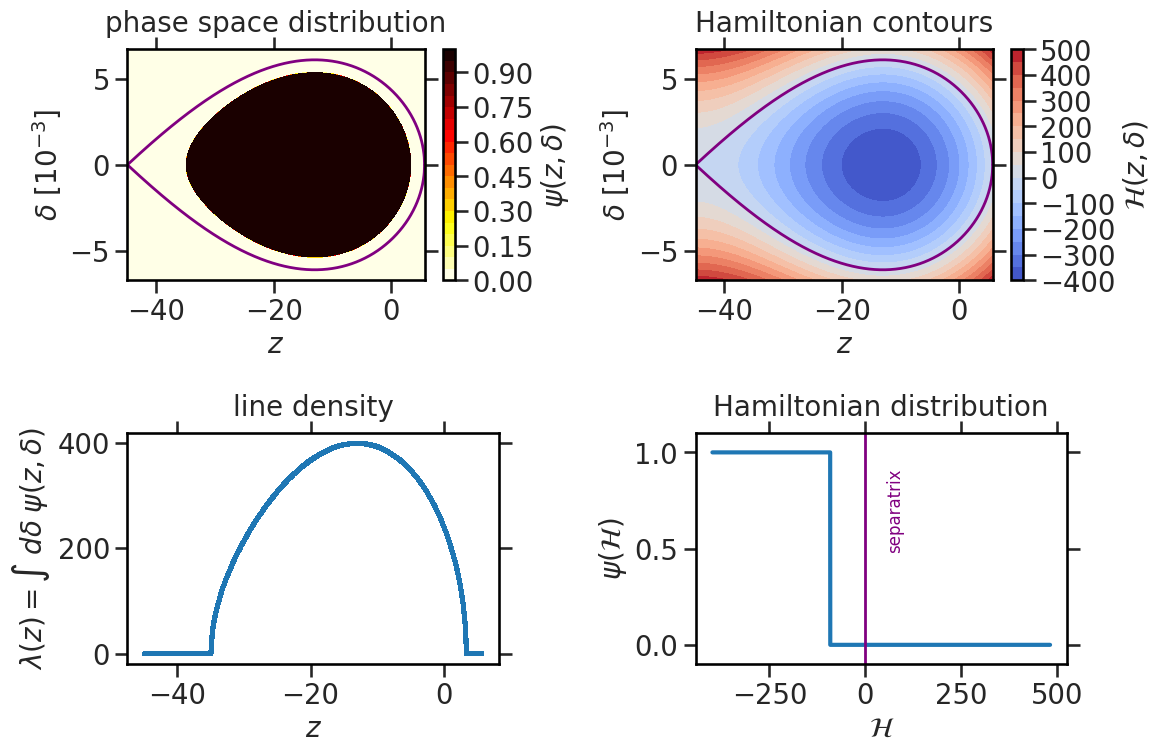

In [26]:
plot_dist(WaterbagDistribution, rfb, H0=H0*2);

<h2>Matching Algorithm</h2>

Given a target rms bunch length $\hat{\sigma}_z$, define the following "matching" algorithm:

1. initial value for $\mathcal{H}_0$ given by small-amplitude approximation (the bi-Gaussian case)
2. compute (numerically) the resulting $\sigma_z$ for full $\psi(\mathcal{H}/\mathcal{H}_0)$
3. compare $\sigma_z$ with target $\hat{\sigma}_z$
4. adjust $\mathcal{H}_0$ (for $\sigma_z<\hat{\sigma}_z$ increase $\mathcal{H}_0$ and vice versa), go to step 2 until converged

This matching algorithm is implemented in the `RFBucketMatcher` class in `PyHEADTAIL`:

In [27]:
from PyHEADTAIL.particles.generators import RFBucketMatcher

In [28]:
rfb_matcher = RFBucketMatcher(rfb, ThermalDistribution, sigma_z=sigma_z)
rfb_matcher.integrationmethod = 'cumtrapz' # better behaved numerical integration method

Calling the `RFBucketMatcher.generate` method will 

(1.) iterate on $\mathcal{H}_0$ until the numerical integration of $\psi(\mathcal{H})$ for the bunch length converges to $\hat{\sigma}_z$, and then 

(2.) sample this $\psi(\mathcal{H})$ by <b>rejection sampling</b> (see previous lecture) to generate the macro-particle phase-space coordinates $(z,\delta)$

In [29]:
z, delta, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS bunch length 8.888845463360669m.
... distance to target bunch length: -7.9156e+00
... distance to target bunch length: 6.5599e-01
... distance to target bunch length: 6.1413e-01
... distance to target bunch length: -3.2377e-01
... distance to target bunch length: 2.5291e-01
... distance to target bunch length: 6.5279e-02
... distance to target bunch length: -4.6398e-03
... distance to target bunch length: 2.6859e-04
... distance to target bunch length: 1.0364e-06
... distance to target bunch length: -8.7361e-06
--> Bunch length: 8.000001036447514
--> Emittance: 2.108543434891298


The relevant code in the `RFBucketMatcher` implementing the rejection sampling:

```python
xmin, xmax = self.rfbucket.z_left, self.rfbucket.z_right
ymin = -self.rfbucket.dp_max(self.rfbucket.z_right)
ymax = -ymin
        
uniform = np.random.uniform
n_gen = macroparticlenumber
u = uniform(low=xmin, high=xmax, size=n_gen)
v = uniform(low=ymin, high=ymax, size=n_gen)
s = uniform(size=n_gen)

def mask_out(s, u, v):
    return s >= self.psi(u, v)

masked_out = mask_out(s, u, v)
while np.any(masked_out):
    masked_ids = np.where(masked_out)[0]
    n_gen = len(masked_ids)
    u[masked_out] = uniform(low=xmin, high=xmax, size=n_gen)
    v[masked_out] = uniform(low=ymin, high=ymax, size=n_gen)
    s[masked_out] = uniform(size=n_gen)
    masked_out[masked_ids] = mask_out(
        s[masked_out], u[masked_out], v[masked_out]
    )
```

Compare the converged value of $\mathcal{H}_0$...

In [30]:
rfb_matcher.psi_object.H0

216.61619727806732

... with the small-amplitude approximation value:

In [31]:
rfb.guess_H0(sigma_z, from_variable='sigma')

153.62263838682642

<p style="color: #e6541a;">$\implies$ are the matched $\mathcal{H}_0$ and the small-amplitude approximation value closer for smaller target $\hat{\sigma}_z$?</p>

Let's have a look at the generated macro-particle distribution:

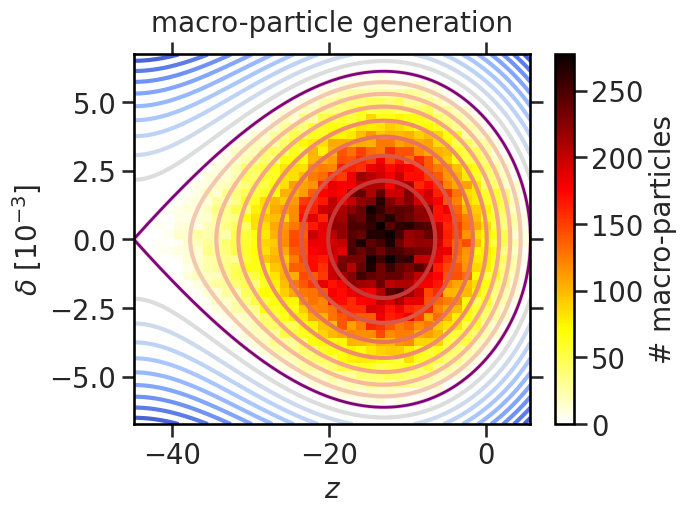

In [32]:
plot_mp(z, delta, rfb);

Does the rms bunch length of the macro-particle distribution match the chosen target $\hat{\sigma}_z$?

In [33]:
np.std(z)

8.00462076948197

In [34]:
sigma_z

8

<div style="text-align: center; width:100%;">
    <h2>Part III: Emittance Preservation & Injection Errors</h2>
</div>

<h2>Sources of Simulated Emittance Growth</h2>

Numerical:
- **distribution not an exact equilibrium distribution** (often the case for Gaussians)
- bad (non-symplectic) numerical integrator

Physical:
- magnet power supply noise, resonances
- multi-particle / collective effects (intra-beam scattering, instabilities)
- **mismatch at injection into synchrotron**

<h2>Section A: Numerical Emittance Growth</h2>

Based on the stationary rf bucket (no acceleration) case, we investigate the difference between initialising a bi-Gaussian and a matched thermal distribution based on the nonlinear Hamiltonian $\mathcal{H}$.

Start with the bi-Gaussian (simulation as previous lecture):

In [35]:
m = Machine(phi_s=0)

In [36]:
sigma_z = 13.5

In [37]:
def generate_gaussian_in_rfbucket(N, sigma_z, machine, seed=12345, margin=0.05):
    '''Generate a bi-Gaussian distribution with N macro-particles,
    rms bunch length sigma_z and a matched sigma_deltap via the
    machine settings.
    '''
    np.random.seed(seed)
    
    m = machine
    
    sigma_deltap = np.sqrt(
        2 * m.p0() / -m.eta(0) * 
        charge * m.voltage * np.pi * m.harmonic / (beta(gamma(m.p0())) * c * m.circumference**2)
    ) * sigma_z

    z_ini = np.random.normal(loc=0, scale=sigma_z, size=N)
    deltap_ini = np.random.normal(loc=0, scale=sigma_deltap, size=N)
    
    H_safetymargin = margin * hamiltonian(0, 0, m)

    H_values = hamiltonian(z_ini, deltap_ini, m) - H_safetymargin

    while any(H_values >= 0):
        mask_bad = H_values >= 0
        N_bad = np.sum(mask_bad)
        print (N_bad)
        # re-initialise bad particles:
        z_ini[mask_bad] = np.random.normal(loc=0, scale=sigma_z, size=N_bad)
        deltap_ini[mask_bad] = np.random.normal(loc=0, scale=sigma_deltap, size=N_bad)
        # re-evaluate rejection condition
        H_values = hamiltonian(z_ini, deltap_ini, m) - H_safetymargin
    
    return z_ini, deltap_ini

In [38]:
N = 10000
n_turns = 5000

In [39]:
z_ini, deltap_ini = generate_gaussian_in_rfbucket(N, sigma_z, m)

860
83
4
1


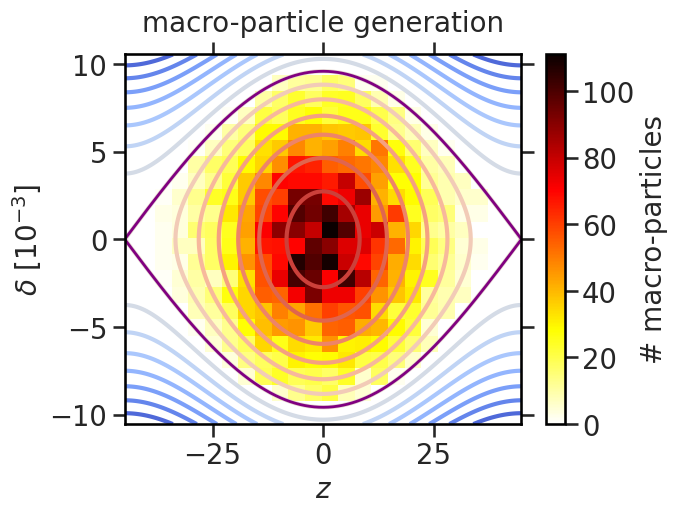

In [40]:
plot_mp(z_ini, deltap_ini / m.p0(), rfb=get_pyht_rfbucket(m), n_bins=20);

Tracking the bi-Gaussian distribution...

In [41]:
z = np.zeros((n_turns, N), dtype=np.float64)
deltap = np.zeros_like(z)

z[0] = z_ini
deltap[0] = deltap_ini

In [42]:
for i_turn in trange(1, n_turns):
    z[i_turn], deltap[i_turn] = track_one_turn(z[i_turn - 1], deltap[i_turn - 1], m)

  0%|          | 0/4999 [00:00<?, ?it/s]

The rms emittance evolution:

In [43]:
epsn_z = np.array([emittance(z_i, deltap_i) for z_i, deltap_i in zip(z, deltap)])

ylim_m = np.median(4 * np.pi * epsn_z / e)
ylim_d = 1.1 * np.max(np.abs(ylim_m - 4 * np.pi * epsn_z / e))

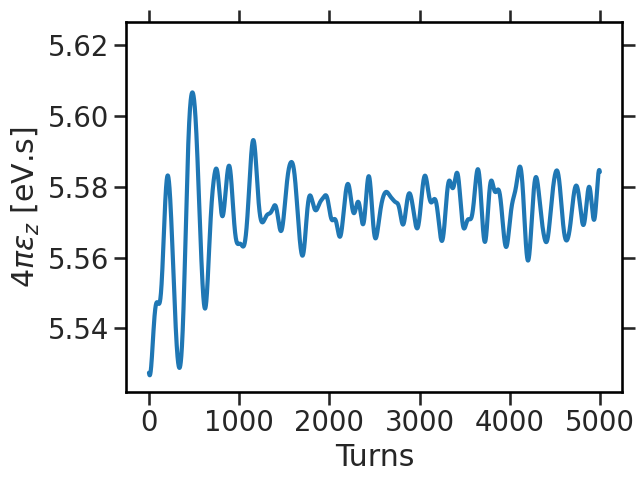

In [44]:
plt.plot(4 * np.pi * epsn_z / e)

plt.ylim(ylim_m - ylim_d, ylim_m + ylim_d)

plt.xlabel('Turns')
plt.ylabel('$4\pi\epsilon_z$ [eV.s]');

$\leadsto$ the Gaussian particle distribution is <b>not exactly</b> in equilibrium for sufficiently large rms values in the nonlinear potential, the particles <b>filament</b> and the rms emittance grows (a little)! 

$\implies$ compare to using full nonlinear Hamiltonian to construct PDF $\psi(\mathcal{H})\propto\exp\left(\cfrac{\mathcal{H}}{\mathcal{H}_0}\right)$

In [45]:
rfb = get_pyht_rfbucket(m)

rfb_matcher = RFBucketMatcher(rfb, ThermalDistribution, sigma_z=sigma_z)
rfb_matcher.integrationmethod = 'cumtrapz'

In [46]:
z_ini, delta_ini, _, _ = rfb_matcher.generate(N)

*** Maximum RMS bunch length 14.146533693849044m.
... distance to target bunch length: -1.3365e+01
... distance to target bunch length: 2.5641e-01
... distance to target bunch length: 2.4078e-01
... distance to target bunch length: -1.8484e-01
... distance to target bunch length: 5.7289e-02
... distance to target bunch length: 1.0673e-02
... distance to target bunch length: -1.5085e-04
... distance to target bunch length: 1.9092e-06
... distance to target bunch length: -4.9149e-06
--> Bunch length: 13.500001909209015
--> Emittance: 5.835458508892962


In [47]:
deltap_ini = delta_ini * m.p0()

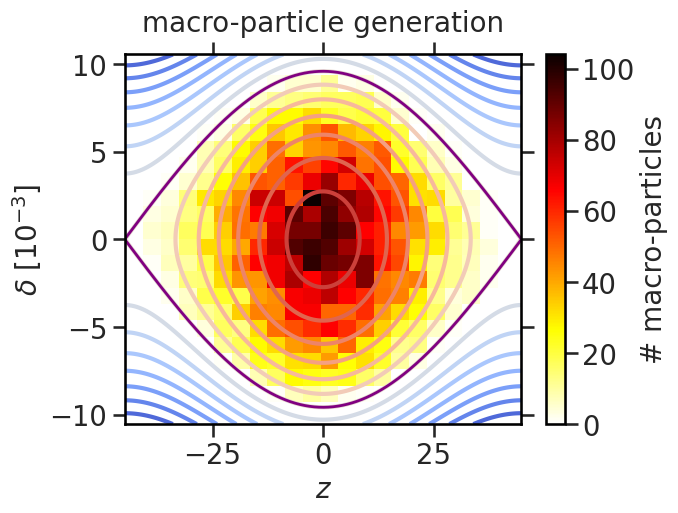

In [48]:
plot_mp(z_ini, delta_ini, rfb, n_bins=20);

Tracking the matched thermal distribution...

In [49]:
z = np.zeros((n_turns, N), dtype=np.float64)
deltap = np.zeros_like(z)

z[0] = z_ini
deltap[0] = deltap_ini

In [50]:
for i_turn in trange(1, n_turns):
    z[i_turn], deltap[i_turn] = track_one_turn(z[i_turn - 1], deltap[i_turn - 1], m)

  0%|          | 0/4999 [00:00<?, ?it/s]

The rms emittance evolution:

In [51]:
epsn_z = np.array([emittance(z_i, deltap_i) for z_i, deltap_i in zip(z, deltap)])

ylim_m = np.median(4 * np.pi * epsn_z / e)

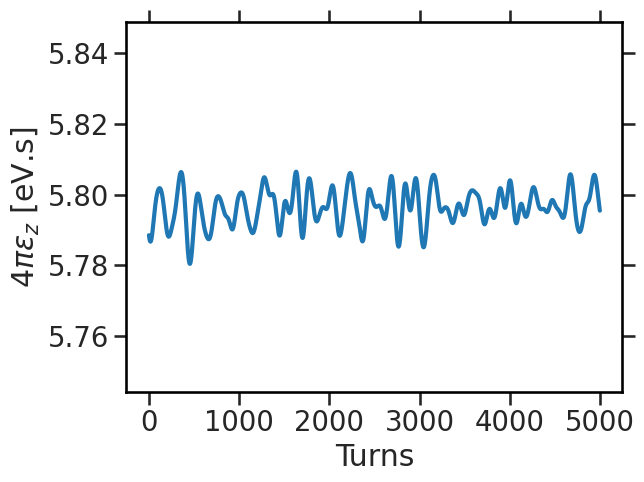

In [52]:
plt.plot(4 * np.pi * epsn_z / e)

plt.ylim(ylim_m - ylim_d, ylim_m + ylim_d)

plt.xlabel('Turns')
plt.ylabel('$4\pi\epsilon_z$ [eV.s]');

$\implies$ this result shows that the nonlinearly matched thermal distribution is in equilibrium from the start (up to macro-particle noise, the fluctuations reduce with $1/\sqrt{N}$)!

<h2>Section B: Dipole Injection Mismatch</h2>

In [53]:
m = Machine(phi_s=0)

sigma_z = 8

z_ini, deltap_ini = generate_gaussian_in_rfbucket(N, sigma_z, m, margin=0.15)

24


Simulate a dipole injection mismatch (e.g. when the rf phase is not well synchronised between the injector and the synchrotron):

In [54]:
z_ini -= 0.5 * sigma_z

4 meter mismatch in $z$ correspond to a phase mismatch of 16 degree:

In [55]:
4 / (m.circumference / m.harmonic) * 360

16.04281826366305

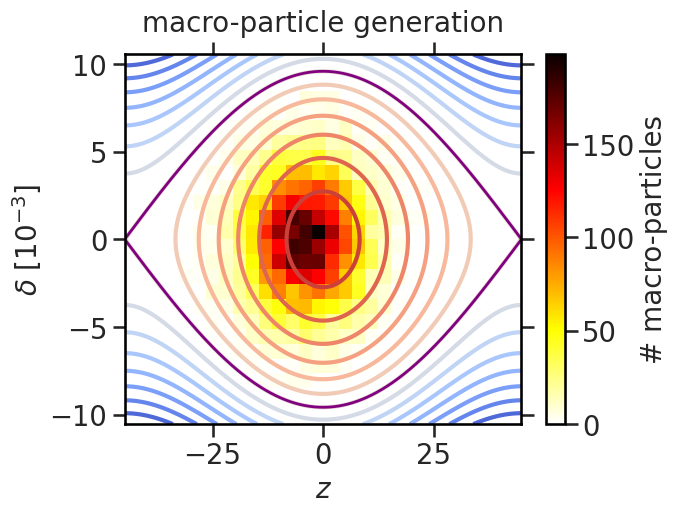

In [56]:
plot_mp(z_ini, deltap_ini / m.p0(), rfb=get_pyht_rfbucket(m), n_bins=20);

$\implies$ note the offset towards negative $z$, the contours of the macro-particle density are no longer matched to the Hamiltonian contours.

The safety `margin` inside the separatrix (where no particles are generated in `generate_gaussian_in_rfbucket`) should be chosen large enough such that no particles are located outside the rf bucket after the mismatch:

In [57]:
assert all(hamiltonian(z_ini, deltap_ini, m) < 0), 'particles have been generated outside the rf bucket!'

Tracking the mismatched distribution of macro-particles:

In [58]:
z = np.zeros((n_turns, N), dtype=np.float64)
deltap = np.zeros_like(z)

z[0] = z_ini
deltap[0] = deltap_ini

In [59]:
for i_turn in trange(1, n_turns):
    z[i_turn], deltap[i_turn] = track_one_turn(z[i_turn - 1], deltap[i_turn - 1], m)

  0%|          | 0/4999 [00:00<?, ?it/s]

<h2>Centroid Results</h2>

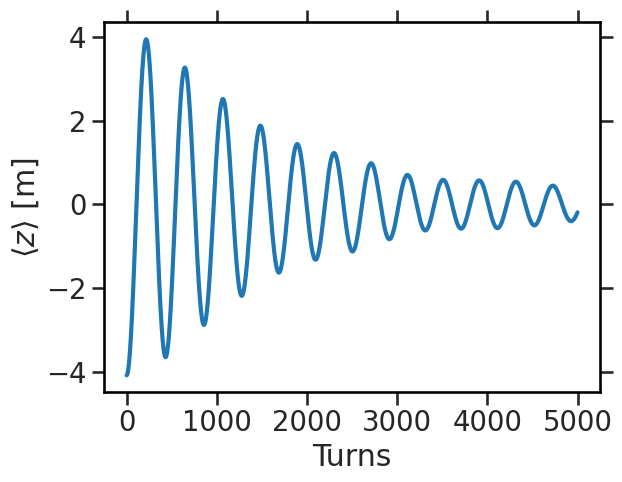

In [60]:
plt.plot(np.mean(z, axis=1))

plt.xlabel('Turns')
plt.ylabel(r'$\langle z \rangle$ [m]');

$\implies$ <b>exponential decay</b> of the initial offset (due to the non-linearity of the rf bucket)

<h2>RMS Bunch Length Results</h2>

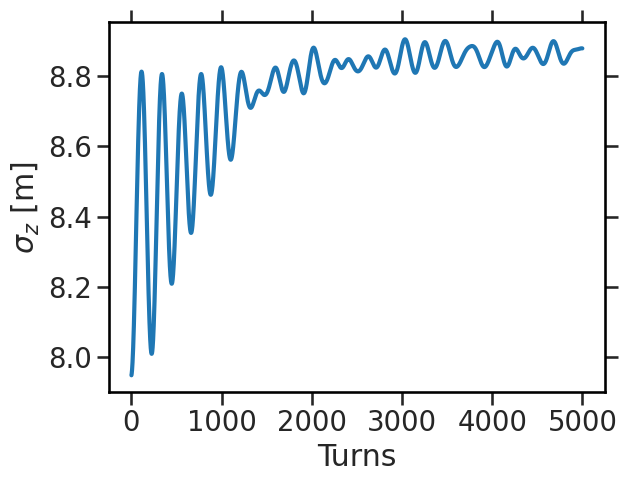

In [61]:
plt.plot(np.std(z, axis=1))

plt.xlabel('Turns')
plt.ylabel(r'$\sigma_z$ [m]');

$\implies$ saturation of the rms bunch length growth

<h2>RMS Emittance Results</h2>

In [62]:
epsn_z = np.array([emittance(z_i, deltap_i) for z_i, deltap_i in zip(z, deltap)])

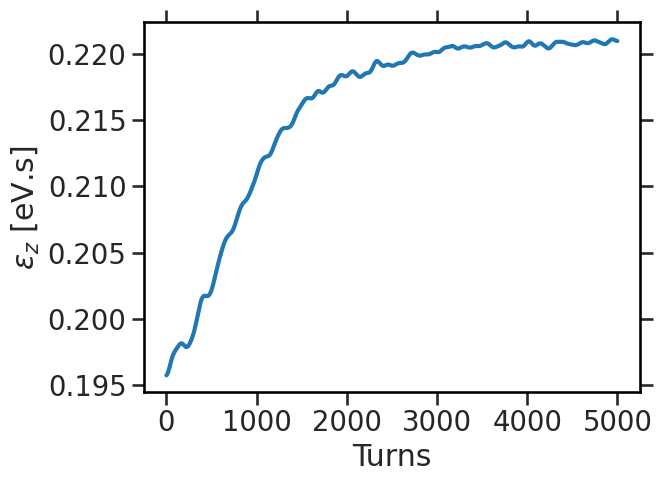

In [63]:
plt.plot(epsn_z / e)

plt.xlabel('Turns')
plt.ylabel('$\epsilon_z$ [eV.s]');

$\implies$ in this example, 10% emittance growth as a result of the 4 meter injection offset.

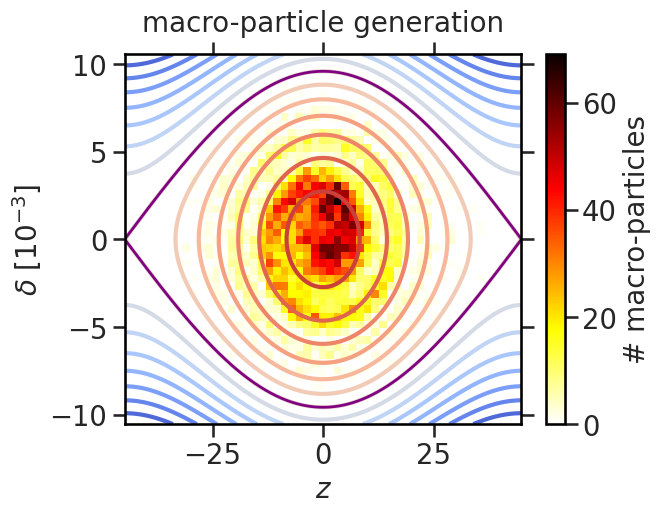

In [64]:
plot_mp(z[-1], deltap[-1] / m.p0(), rfb=get_pyht_rfbucket(m), n_bins=40);

$\implies$ the filamentation of the macro-particle distribution is clearly visible!

<h2>Section C: Quadrupole Injection Mismatch</h2>

In [65]:
m = Machine(phi_s=0)

sigma_z = 8

z_ini, deltap_ini = generate_gaussian_in_rfbucket(N, sigma_z, m, margin=0.15)

24


Simulate a quadrupole injection mismatch (e.g. when the rf voltage (rf bucket height) is not matched between the injector and the synchrotron):

In [66]:
deltap_ini *= 0.5

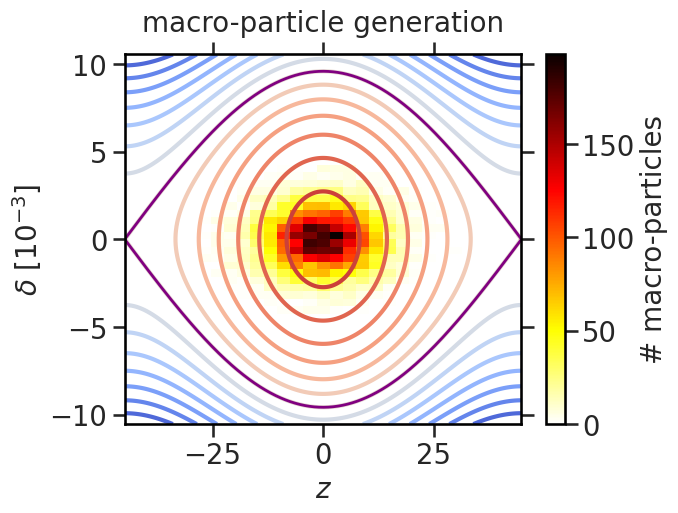

In [67]:
plot_mp(z_ini, deltap_ini / m.p0(), rfb=get_pyht_rfbucket(m), n_bins=20);

$\implies$ note the squeezed rms momentum spread, the contours of the macro-particle density are no longer matched to the Hamiltonian contours.

Tracking the mismatched distribution of macro-particles:

In [68]:
z = np.zeros((n_turns, N), dtype=np.float64)
deltap = np.zeros_like(z)

z[0] = z_ini
deltap[0] = deltap_ini

In [69]:
for i_turn in trange(1, n_turns):
    z[i_turn], deltap[i_turn] = track_one_turn(z[i_turn - 1], deltap[i_turn - 1], m)

  0%|          | 0/4999 [00:00<?, ?it/s]

<h2>Centroid Results</h2>

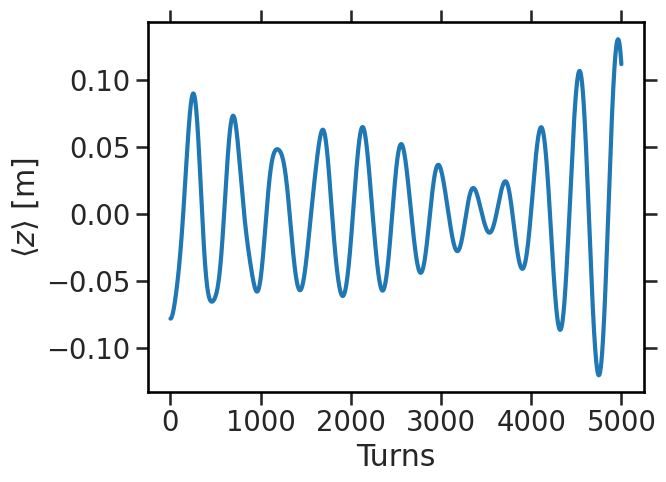

In [70]:
plt.plot(np.mean(z, axis=1))

plt.xlabel('Turns')
plt.ylabel(r'$\langle z \rangle$ [m]');

$\implies$ only residual centroid fluctuations (due to macro-particle noise)

<h2>RMS Bunch Length Results</h2>

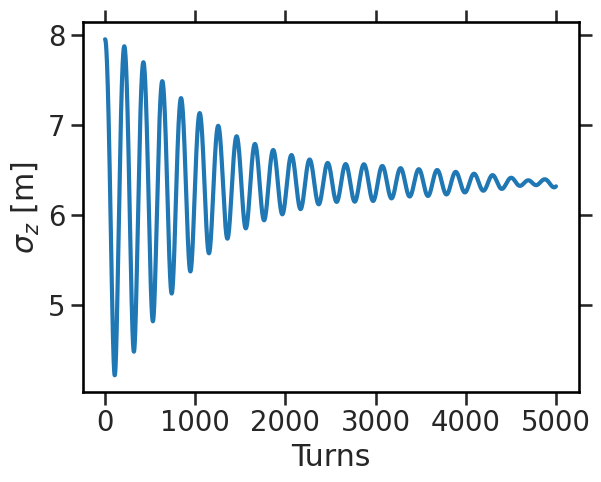

In [71]:
plt.plot(np.std(z, axis=1))

plt.xlabel('Turns')
plt.ylabel(r'$\sigma_z$ [m]');

$\implies$ <b>exponential decay</b> of the initial momentum mismatch (due to the non-linearity of the rf bucket)

<h2>RMS Emittance Results</h2>

In [72]:
epsn_z = np.array([emittance(z_i, deltap_i) for z_i, deltap_i in zip(z, deltap)])

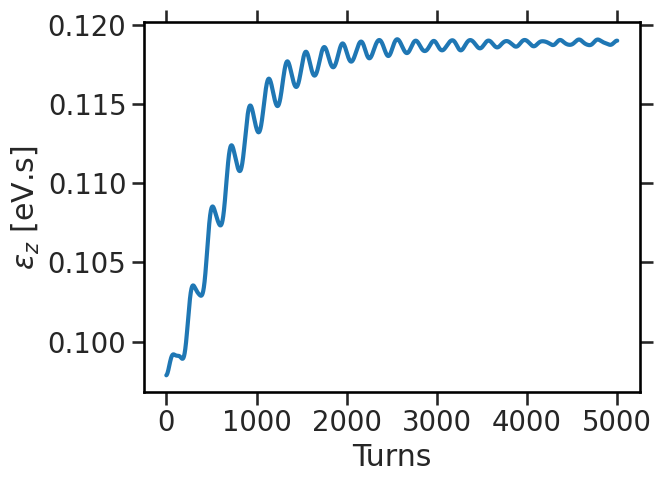

In [73]:
plt.plot(epsn_z / e)

plt.xlabel('Turns')
plt.ylabel('$\epsilon_z$ [eV.s]');

$\implies$ in this example, 20% emittance growth as a result of the 50% momentum spread mismatch.

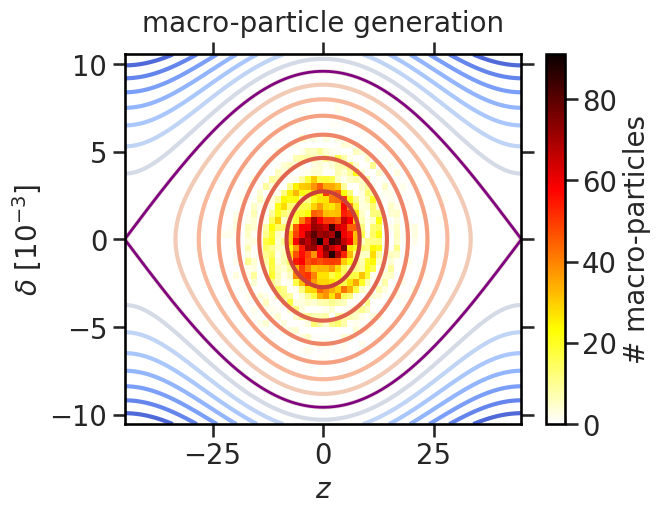

In [74]:
plot_mp(z[-1], deltap[-1] / m.p0(), rfb=get_pyht_rfbucket(m), n_bins=40);

$\implies$ again, the filamentation of the macro-particle distribution is clearly visible!

<h2>Summary</h2>

- full simulation of acceleration ramp, incl. transition crossing (and necessary synchronous phase adjustments!)
- equilibrium distributions with nonlinear Hamiltonian
- matching algorithm to find $\mathcal{H}_0$ (given target rms bunch length $\hat{\sigma}_z$)
- emittance growth mechanisms (dipole and quadrupole injection mismatch)

<h2>PS: Solving the Exercise in Part I</h2>

To avoid the emittance growth in the simulation of the acceleration ramp in the CERN Proton Synchrotron, the operators should switch the synchronous phase at transition energy in order to restore phase focusing. (The previous lectures provide the conceptual background to understand what is going on.)

The switch in the synchronous phase can be implemented in the tracking loop as follows:
- compute the new synchronous phase for the *relativistic regime* from the initial `m.phi_s` (which determines the energy gain) and store the value in a variable, e.g. `phi_s_1`, before the tracking starts
- define the condition where transition energy is crossed
- if this condition is met, set the synchronous phase `m.phi_s` to the correct new value `phi_s_1`

```python
phi_s_1 =  # compute here the correct new synchronous phase above transition
# by using the one from below transition which is m.phi_s

for i_turn in trange(1, n_turns):
    z, deltap = track_one_turn(z, deltap, m)
    
    epsn_z[i_turn] = emittance(z, deltap)
    
    condition =  # write here X > Y after the "="
    if condition:
        m.phi_s = phi_s_1
```